# **Homework 3**

In HW1, we manually built our own text adventure games.  In HW2, we created a GPT Parser that could create evocative descritpions and do better understanding of user commands.  In this HW, we are going to try to use GPT to generate games.  Our goal for this HW is to take a few paragraphs of a work of fiction as input, and then generate a game as output.

We'll approach this via fine-tuning GPT 3.5 to translate between fiction and a JSON data structure that we can load into our `text_adventure_game` format.  In order to do this we'll need a few hundred examples of fiction stories paired with an appropriate JSON output that represents that story in our game format.  

Where can we get that kind of data?  It doesn't exist, so we'll create a synthetic data set that approximates whT we want.  To create our synthetic data, we'll start with a few hundred game locations, and then have GPT-4 write fiction that takes place in that location.  The games will come from a dataset called **LIGHT** (Learning in Interactive Games with Humans and Text) that has several hundred locations, and several thousand characers and items.

After we have created the synthetic data of (fiction, JSON) pairs, we'll fine tune a model on that data.  After we have fine-tuned the model, we will try to generate a new game given a story as input.

This HW will have 3 main parts:
1.  **Generate synthetic data** - You will familiarize youself with the LIGHT data and its JSON representation.  Given a JSON of a game state, you'll prompt GPT-4 to generate literary fiction in zero-shot fashion.  We'll generate fiction for 100 game states from LIGHT.  This will be our synthetic data set.   For this part will also experiment with "prompt augmentation" to make our fiction more interesting. 
2.  **Fine-tune a model on your data** -  We will fine-tune GPT-3.5 to on our synthetic dataset.  We'll reverse the order of the inputs and outputs from part 1.  We'll use the fiction stories and as input, and genrate the game state for the story as output.
3.  **Create a game from a story** -  After fine tuning, we will have you create game states from a story of your chosing or a story that you have written.  After you the generate the game states of the locations in JSON format, you will editing them into a playable game.

# Part 1: Generate synthetic data


## The LIGHT data

Facebook AI Research released a dataset for their paper [Learning to Speak and Act in a Fantasy Text Adventure Game](https://arxiv.org/abs/1903.03094). Their data is called the **LIGHT** dataset (Learning in Interactive Games with Humans and Text). It contains several hundred locations, and several thousand characters and objects.  I have preprocessed the LIGHT data and converted into a format that is usable with our `text_adventure_games` package. I have created one game file for each of the environments in the LIGHT dataset, and saved them as JSON files that can be read into `text_adventure_games`. 

Download `games-updated.zip` file from the homework3 webpage and unzip it. You will have a folder named `games-updated` which contains multiple JSON files.  Each JSON file has one game which has the characters, locations, and items similar to the Action Castle that we started with. Put the directory `games-updated` in the same directory as this hw3 notebook is contained in.

Here is how you load one of the JSON files.  

In [ ]:
from collections import defaultdict
from getpass import getpass
from copy import deepcopy

import json
import os
import random

# Checking one file
with open("games-updated/port.json", 'r') as f:
    data = json.load(f)

### Optionally, play a game

We created the JSON format so that we could save and load games.  Therefore, you can play this file.

In [ ]:
from text_adventure_games import games
from text_adventure_games.parsing import Parser

game = games.Game.from_primitive(deepcopy(data))
parser = Parser(game)
game.set_parser(parser)
# game.game_loop()

If you'd like to try the game with the GPT Parser from HW2, you can try my implementation.  

In [ ]:
from homeworks.hw2_solution.gpt_parser import GptParser

game = games.Game.from_primitive(deepcopy(data))
parser = GptParser(game, verbose=False, narration_style="Using a dark fantasy suspense style, reveal the scene from a second-person perspective. Paint a vivid picture of the unusual surroundings.")
game.set_parser(parser)
# game.game_loop()


You can visualize the game structure just like we did for Action Castle in HW1.

In [ ]:
from text_adventure_games.viz import Visualizer
from text_adventure_games import games

game = games.Game.from_primitive(deepcopy(data))
viz = Visualizer(game, verbose=False)
graph = viz.visualize()
# graph

### The JSON format

Here's what a LIGHT location looks like in the JSON format that can be loaded by our `text_adventure_game`.  It has 
* a `name` for the location
* a `category` shared by all of the locations in this file
* a `description` of the location
* `background` information about the location (used by LIGHT but not by our game)
* a set of special `commands` that can be used at the location
* a dictionary of `connections` mapping from directions onto connected locations
* `travel_descriptions` provides a short narrative describing what it is like to travel to each connected location
* `blocks` is a dictionary of which connections are blocks (used in our games but not in LIGHT)
* `items` is a dictionary of items found at this location.  Items have a JSON specification.
* `characters` is a dictionary of characters found at this location. Characters have a JSON specification.
* `has_been_visited` a boolean indicating whether the player character has visited this location (defaults to `false`)
* `commands` a list of special commands that are associated with this location (empty since this is used by our game but not by light)
* `properties` an optional dictionary of properties associated with this location (defaults to `{}`)



Here's an example of an instantiated JSON for the LIGHT location `Wharf` from the `Port` cateogry.  

```
{
    "name": "Wharf",
    "category": "Port"
    "description": "The waves lash gently against the wooden posts, the water here has always been calm and passive, it seems to represent the people of this small town. The fishermen here are not boisterous, they are quiet, at least when it comes to sound. They'll talk your ear off if you let them, they have lots of stories to tell. The pier here is long, it extends at least forty feet into the ocean, many ships are anchored to it, many people traverse down it buying and selling their local catches.",
    "background": "The port is just like any other port. Busy with the bustle and hustle of people buying and selling whatever they can. A connection to the rest of the world, so you'll see people who look like they belong and you'll see people new here as well. You'll also run into a few people who can't afford to buy and will take things from those who may not be paying full attention.",
    "connections": {
        "north": "Port Skyline",
        "east": "Loading Dock",
        "south": "Fish Market"
    },
    "travel_descriptions": {
        "north": "Journeying north to Port Skyline, the hum of the city grows louder as it comes into view, replacing the tranquil sound of water lapping against the pier with the hustle and bustle of a city alive.",
        "east": "Heading east towards the Loading Dock, the air thickens with the scent of seaweed and salt, intermixed with the heavy smell of cargo and fresh timber.",
        "south": "Making your way south to the Fish Market, the calls of merchants and the splash of fish hitting ice fill the air, while the salty sea breeze intertwines with the scent of freshly-caught seafood."
    },
    "blocks": {},
    "items": {
        "Old Fishing Net": {
            "name": "Old Fishing Net",
            "description": "A weather-beaten fishing net with traces of sea salt and algae.",
            "examine_text": "Upon a closer look, you can see the faded color and fraying threads of the old fishing net. It has seen better days, worn by countless fishing trips and seasoned by the relentless ocean winds.",
            "properties": {
                "is_container": true,
                "is_drink": false,
                "is_food": false,
                "is_gettable": true,
                "is_surface": false,
                "is_weapon": false,
                "is_wearable": false
            },
            "location": "Wharf"
        },
        "Sailor's Hat": {
            "name": "Sailor's Hat",
            "description": "A sturdy, white sailor hat with blue rimming.",
            "examine_text": "Gazing at the sailor's hat, you can feel the culture behind it. There are salt stains and a clear sign of sun fading on it. The fabric is thick and made to last in the harsh marine environment.",
            "properties": {
                "is_container": false,
                "is_drink": false,
                "is_food": false,
                "is_gettable": true,
                "is_surface": false,
                "is_weapon": false,
                "is_wearable": true
            },
            "location": "Wharf"
        },
        "Fresh Fish": {
            "name": "Fresh Fish",
            "description": "A recently caught and cleaned fish, ready for cooking.",
            "examine_text": "Examining the fish, it's glistening and healthy, with eyes clear and bulging. The scent is relatively mild and the flesh firm, clear signs it was recently caught and cleaned.",
            "properties": {
                "is_container": false,
                "is_drink": false,
                "is_food": true,
                "is_gettable": true,
                "is_surface": false,
                "is_weapon": false,
                "is_wearable": false
            },
            "location": "Wharf"
        },
        "Fishing Rod": {
            "name": "Fishing Rod",
            "description": "A long, flexible rod used for fishing.",
            "examine_text": "As you examine the fishing rod, you can see the well-worn handle from years of use. The line seems sturdy and the hook sharp enough to snag any fish.",
            "properties": {
                "is_container": false,
                "is_drink": false,
                "is_food": false,
                "is_gettable": true,
                "is_surface": false,
                "is_weapon": true,
                "is_wearable": false
            },
            "location": "Wharf"
        },
        "Shipping Crate": {
            "name": "Shipping Crate",
            "description": "A large wooden crate used for shipping goods.",
            "examine_text": "Taking a closer look at the shipping crate, you can see the tough wooden panels and hefty iron clasps that hold it together. The crate is filled with an assortment of goods, ready for transport.",
            "properties": {
                "is_container": true,
                "is_drink": false,
                "is_food": false,
                "is_gettable": false,
                "is_surface": true,
                "is_weapon": false,
                "is_wearable": false
            },
            "location": "Wharf"
        }
    },
    "characters": {
        "Pete the Fisherman": {
            "name": "Pete the Fisherman",
            "description": "A seasoned fisherman with a deep tan and gnarled hands from years of casting nets.",
            "persona": "Aye, it's a tough life, but there's nothin' like it. To be out on the sea, feelin' the tug of a heavy net full of fish.",
            "location": "Wharf",
            "goal": "Catch the most elusive fish in the sea.",
            "inventory": {
                "Old Fishing Rod": {
                    "name": "Old Fishing Rod",
                    "description": "An aged, yet reliable fish-catching device owned by Pete the Fisherman.",
                    "examine_text": "A sturdy rod made of old and polished oak. Its line, although thin and almost invisible, is made from a super-strong, modern fishing wire. The reel, rusted over time, still turns smoothly, and the cork handle is worn down from Pete's persistent grip. This rod might be old, but the stories it could tell would draw the envy of many.",
                    "properties": {
                        "is_container": false,
                        "is_drink": false,
                        "is_food": false,
                        "is_gettable": false,
                        "is_surface": false,
                        "is_weapon": false,
                        "is_wearable": false
                    },
                    "commands": []
                },
                "Fish": {
                    "name": "Fish",
                    "description": "A silvery, shiny fish caught by Pete the Fisherman.",
                    "examine_text": "Gleaming scales catch the light, giving the fresh catch a brilliant shine. It's a medium-sized fish, a common sight in the catches made by Pete. Lifelike eyes stare blankly, testament to how recently it was pulled from the ocean's depths. Beneath the smell of the sea, there's a richness--an aroma that promises a delicious meal.",
                    "properties": {
                        "is_container": false,
                        "is_drink": false,
                        "is_food": true,
                        "is_gettable": true,
                        "is_surface": false,
                        "is_weapon": false,
                        "is_wearable": false
                    },
                    "commands": []
                },
                "Hardtack": {
                    "name": "Hardtack",
                    "description": "A hard slab of simple biscuit, common food for sailors.",
                    "examine_text": "The hardtack is essentially a slab of hard, baked flour. It's not the most appetising of Pete's meals, but it serves well enough when there's nary a nibble on the rod. The bread's surface is dry and covered with small holes, likely made to help baking. Despite its simplistic look, this hardtack could very well save you from hunger in a pinch.",
                    "properties": {
                        "is_container": false,
                        "is_drink": false,
                        "is_food": true,
                        "is_gettable": true,
                        "is_surface": false,
                        "is_weapon": false,
                        "is_wearable": false
                    },
                    "commands": []
                }
            }
        }
    },
    "has_been_visited": false,
    "commands": [],
    "properties": {},
}
```

## Generating Interesting Fiction from Locations

Now that you're familiar with the data, it is time to generate literary descriptions of these locations to create our synthetic dataset.   Our goal is to create descriptions in the style of literary fiction from our JSON files, so that we can later flip the order and generate game files from stories. 

Here's an example of a story that I generated for the `Wharf` location:

> The wharf was a moving portrait of all kinds of people, their lives intertwining between the echoes of seagulls and whining harbors. Further out, around the belly of the ocean, fishing vessels stared down the sky’s hues with worn, indomitable masks, their mastheads wearing the day’s progress like a badge. The tranquil sea slapped against wooden supports with a rhythmic pulse, telling tales of today’s catch and the whisper of tomorrow’s promises.
>
> Among them, Pete the Fisherman, a stalwart silhouette against sun’s retention, retained his solitary stance. His deep tan reflected years under the blazing sun, his gnarled hands bound to his eternal companions, an old net and a sturdy fishing rod. The net, worn by time and the sea’s impudent temper, was a patchwork of repair and resilience—telling tales of fish captured and those that escaped. His reel, rusted over from the salt and ocean fog, still loyal to the touch, spun out lines thinner than a whisper, but tenacious as the man casting it. 
>
> Where outsiders hustled and bustled around, Pete carved his peace, a fluid rhythm of casting the line, subtle tension in the wait, and the sweet tug of victory. His memory, a spectral assembly of various fish that made a momentary tryst with his net, was never quite satisfied. His heart rumbled with the desire to conquer the ocean’s whims, to bring ashore a legendary beast from folktales, the town's most elusive fish. 
>
> For a few moments, he’d lose himself in the vibrancy around him. Kids scampering across the pier, their laughter riding on the ocean breeze like whimsical promises. Vendors hawking the day’s fresh catch, their voices floating over the symphony of clinking riggings and slapping waves. A wafting scent bullies the crisp ocean air--a medley of fresh fish, the briny sea, and the worn wood. All of this spelled home, an anchor as steadfast as the wooden posts of the wharf.
>
> But more often than not, his gaze slipped into the undulating depths, a spark in its blue winking back with a challenging glint. Pete, the silent pillar amidst the chaos of daily life, always nursing his pipe dream of the elusive catch, knew the true symphony of the sea lay beneath its dance with the sky. Beneath where vision surrendered to imagination—the arena of the deep-sea king he meant to befriend with his worn, resilient net one day.

To get that output, I prompted GPT-4 with these instructions, followed by the JSON for the `Wharf`:

> "Write a scene for a literary fiction novel that takes place in a bustling seaside wharf. Use the 3rd person narrative style to vividly describe the atmosphere of the bustling port and the daily lives of its inhabitants, particularly focusing on Pete the Fisherman. Examine Pete's appearance, behavior, the fishing tools he uses, and his interactions with the others in his town. Make sure to emphasize the sensory details - the sights, sounds, smells, and sensations of the wharf - to create an immersive setting. Also, provide a deeper exploration of Pete's thoughts and feelings, hinting at his underlying dreams and desires to catch the most elusive fish in the sea, to convey the human conditions at play."

How did I write such a great prompt?  The answer is that I didn't, GPT-4 did!  I used "prompt agumentation" to have GPT create a better prompt starting with one that I wrote.

Prompt augmentation is common for image generation systems like DALLE-3, where a simple prompt like "make a picture of a wharf" gets augmented to be more elaborte 
> A picturesque scene of a bustling wharf at sunset. The wharf is filled with activity, featuring docked boats of various sizes, from small fishing vessels to larger sailboats. People are seen walking along the wooden planks, some carrying fishing gear, while others are engaged in lively conversations. The setting sun casts a golden hue over the scene, with the water reflecting the vibrant colors of the sky. Seagulls fly overhead, adding to the lively atmosphere. The background shows a distant view of the town, with quaint buildings and a few trees dotting the landscape.

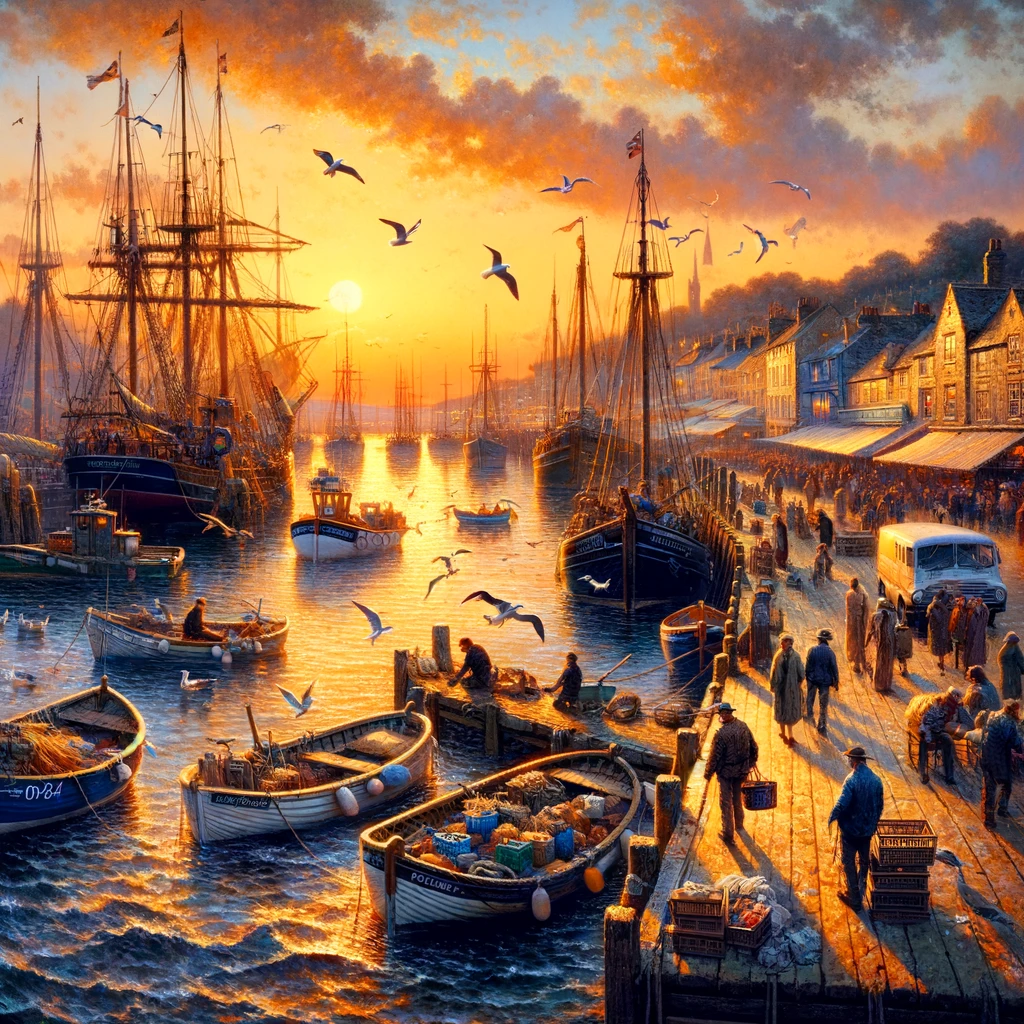

### Prompt Augmentation 

Here's how [my prompt augmentation](https://platform.openai.com/playground/p/gEGpSyVuePUIAkHQefP2RQJh?model=gpt-4&mode=chat) worked:
1. I started with the prompt "Imagine that this was going to form the scene in a novel.  What style of novel would it be?  Would it be narrated in the 3rd person?  Past tense?  If there are multiple characters, and we found them in medias res, what would the conversation be about?"   
2. I gave GPT-4 the JSON a game location `The Show Room Inside The Castle`.
3. GPT output the response "This scene would likely be in a historical fantasy or suspense novel. It could be narrated in the 3rd person to provide insights into the thoughts and feelings of the characters along with detailed descriptions of the objects in the room. The novel would likely be written in past tense, common to many novels in these genres.  If we stumbled upon them in the middle of a conversation (in medias res), they might be discussing the Duke's next big conquest. However, underlying their conversation could be the tense relationships and hidden agendas. Lady Isolde might subtly be trying to pry information from the Duke about his hunting practices, wrapped in feigned admiration, while Sir Lionel provides a vigilant watch, only speaking to divert attention or suspicion from Lady Isolde's intent."
4. I asked it to "Rewrite that response to be a prompt describing how to write the scene."
5. It replied with the final prompt that I used for the scene, which was:

> Write this scene for a historical fantasy or suspense novel. Use a 3rd person narration to provide a deep understanding of the characters' thoughts and emotions, as well as to describe the environment and objects in the room in detail. Opt for past tense, as it's the common tense for these genres. 
>
> Start your scene in medias res, or in the middle of a conversation. Have your characters engaged in a discussion about the Duke's next grand hunting conquest. As part of the dialogue, ensure that the power dynamics and hidden agendas are subtly highlighted. For instance, Lady Isolde should be written as seemingly praising the Duke's hunting exploits, but her genuine motive is to gain insights about his cruel hunting methods. Simultaneously, present Sir Lionel as a vigilant protector who speaks less and observes more, diverting attention or suspicion from Lady Isolde whenever necessary. The tensions between the characters and the secrets they conceal should add an underlying suspense to their conversation.

In a new conversation with GPT, I gave it that prompt, along with the JSON for the `The Show Room Inside The Castle` location, and it [output a literary scene](https://platform.openai.com/playground/p/ecEE4OOuDIgO7xB5t9W8mLfO?model=gpt-4&mode=chat).

## TODO: Create agumented prompts and descriptions for the LIGHT data

We are going to generate sythetic data using GPT-4 to convert the LIGHT scenes into prose that is like what you might find in a novel. In part 2, we are going to fine-tune a model which generates the game state given a scene in a novel or short story. 

Your task will be to generte a literary description for the description for each location assuming that one location represents one current game state.

The data format for yoru synthetic data is:
```
[
    {
        'location': {...},  # The location input (a JSON dict from our game file)
        'initial_prompt': # The prompt that you started with (it's OK if this is the same for every location)
        'augmented_prompt': # The augmented prompt your generated with GPT.
        'description': "...",  # The description that was generated using your augumented prompt.
    },
    {
        'location': {...},
        'initial_prompt': "...",
        'augmented_prompt': "...", 
        'description': "...",
    },
    {
        ...
    },
    ...
]
```

Note that generating all location descriptions will likely take __several hours__, so I recommend starting with only a few examples and making sure that you like your augmented prompts before you apply your pipeline to the whole LIGHT dataset. 

### Helicone wrapper for OpenAI

To save you money with all of your prompting to GPT-4, you can use the Helicone account for the class. You should set your Helicon API Key (which you can find [here](https://www.helicone.ai/developer)) on the terminal with the command `export HELICONE_API_KEY=sk-helicone-cp-###########`. If you're using VS Code, you can launch it from your terminal with the `code` command and prefix it with this export statement on the same line. For example:

```
cd your/homework/dir
source venv/bin/activate
HELICONE_API_KEY=sk-helicone-cp-###########  code .
```

Alternatively, you can enter it by running the next cell. For more information on using the Helicone proxy, see [this Ed post](https://edstem.org/us/courses/50468/discussion/4413041).

In [ ]:
if 'HELICONE_API_KEY' not in os.environ:
    print("You didn't set your Helicone key to the HELICONE_API_KEY env var on the command line.")
    os.environ['HELICONE_API_KEY'] = getpass("Please enter your Helicone API Key now: ")

In [ ]:
from openai import OpenAI
client = OpenAI(base_url="https://oai.hconeai.com/v1", api_key=os.environ['HELICONE_API_KEY'])

#### Load the LIGHT locations

Here's how to load the locations.  While you're experimenting with your prompt augmentation pipeline, I recommend using a small subsample, like 10 locations.  Once you're happy with it, you can use the full data.  If you're running short on time, you can limit your final run to be 100 locations. 

In [ ]:
import json
import os
import random

In [ ]:


def load_locations(games_dir, sample_size=-1):
    locations = []
    game_files = [file for file in os.listdir(games_dir) if file.endswith('.json')]
    for game_file in game_files:
        with open(os.path.join(games_dir, game_file), 'r') as f:
            data = json.load(f)

        for location in data['locations']:
            locations.append(location)

    # if sample_size > 0:
    #     random.shuffle(locations)
    #     locations = locations[0:sample_size]

    return locations


# locations = load_locations("games-updated", sample_size=2)
locations = load_locations("games-updated")

In [ ]:
len(locations)

#### TODO: Write your prompt augmentation code

In [ ]:
from openai import OpenAI
import time

In [ ]:


def augment_prompt(initial_prompt: str, location: dict) -> str:
    augmented_prompt = ""
    messages = [
      {'role': 'system', 'content': initial_prompt},
      {'role': 'user', 'content': f"{json.dumps(location, indent=4)}"}
    ]

    client = OpenAI(base_url="https://oai.hconeai.com/v1", api_key=os.environ['HELICONE_API_KEY'])

    response = client.chat.completions.create(
      model='gpt-4',
      messages=messages,
      temperature=1,
      max_tokens=2048,
      top_p=1.0,
      frequency_penalty=0,
      presence_penalty=0
    )
    gpt_response = response.choices[0].message.content
    # TODO - your prompt agumentation code here...

    prompt2 = """Turn this paratraph into a prompt for a LLM to describe how to write the scene. 
                 Also let it know that it shouldn't mention anything that is not in the given information.
                 Output only the prompt. Start with describe a scene ...
            """
    prompt2 = prompt2.replace('\n', ' ')
    messages2 = [
      {'role': 'system', 'content': prompt2},
      {'role': 'user', 'content': gpt_response}
    ]
    augmented_prompt = client.chat.completions.create(
      model='gpt-4',
      messages=messages2,
      temperature=1,
      max_tokens=2048,
      top_p=1.0,
      frequency_penalty=0,
      presence_penalty=0
    )

    augmented_prompt = augmented_prompt.choices[0].message.content
    return augmented_prompt


def create_synthetic_data(locations, output_filename="synthetic_data.json"):
    augmented_prompts = []
    if os.path.exists(output_filename):
        with open(output_filename, 'r') as f:
            augmented_prompts = json.load(f)
    cnt = 0
    for location in locations:
        data = {}
        initial_prompt = """
            Imagine that this was going to form the scene in a novel.  
            What style of novel would it be?  Would it be narrated in the 3rd person?  Past tense?  
            If there are multiple characters, and we found them in medias res, what would the conversation be about?
            """  # TODO - your initial prompt here...
        time.sleep(15)
        augmented_prompt = augment_prompt(initial_prompt, location)
        
        data['location'] = location
        data['initial_prompt'] = initial_prompt
        data['augmented_prompt'] = augmented_prompt
        augmented_prompts.append(data)
        with open("synthetic_data.json", 'a') as file:
          if os.path.getsize("synthetic_data.json") > 0:
            file.write(',\n')
          json.dump(data, file, indent=4)
        cnt += 1
        if cnt % 5 == 0:
          print(cnt)


    # with open("synthetic_data.json", 'a') as file:
    #     json.dump(augmented_prompts, file, indent=4)
    return augmented_prompts
        
augmented_prompts = create_synthetic_data(locations, output_filename="synthetic_data.json")


In [ ]:
# Print out some of your results to see if you like them.
augmented_prompts_samples = random.sample(augmented_prompts, 10)
for data in augmented_prompts_samples:
  print('-' * 100)
  print("Location:")
  location = data['location']
  print(json.dumps(location, indent=4))

  print("Augmented Prompt:")
  print(data['augmented_prompt'])

  print("\n")

Once you're happy with your augmented prompts, you can apply them to generate descriptions for each of the locations.  You don't need to write any code here.

In [ ]:
def apply_prompt(prompt: str, location: dict) -> str:
    messages = [
      {'role': 'system', 'content': prompt},
      {'role': 'user', 'content': f"{json.dumps(location, indent=4)}"}
    ]

    client = OpenAI(base_url="https://oai.hconeai.com/v1", api_key=os.environ['HELICONE_API_KEY'])

    response = client.chat.completions.create(
      model='gpt-4',
      messages=messages,
      temperature=1,
      max_tokens=2048,
      top_p=1.0,
      frequency_penalty=0,
      presence_penalty=0
    )
    # print(response.choices[0].message.content)
    return response.choices[0].message.content


def apply_augmented_prompts(output_filename):
    with open(output_filename, 'r') as f:
        augmented_prompts = json.load(f)
    cnt = 250
    for data in augmented_prompts[250:]:
        location = data['location']
        initial_prompt = data['initial_prompt']
        augmented_prompt = data['augmented_prompt']
        description = apply_prompt(augmented_prompt, location)
        data['description'] = description
        if cnt % 10 == 0:
            print(cnt)
        cnt += 1
    
    with open("synthetic_data.json", 'w') as file:
        json.dump(augmented_prompts, file, indent=4)

In [ ]:
apply_augmented_prompts("synthetic_data.json")

Take a look at whether the result is satisfying or not. The model sometimes hallucinates the content, for example, the item or character which does not exist in the scene might be made up by the model.

Sample the examples multiple times and analyze your results. You can write about the problems if you've found any or about the good examples along with the reason why you picked them.

TODO: Add some examples of your augmented prompts and the descriptions that they produced to your README.txt, along with your analysis.

# Part 2: Fine-tune a model on your data

For this part, you will fine-tune GPT 3.5 on your synthetic data.  You'll create a fine-tuning data file. It'll have 3 components for each training item:
1. Sytem instructions - describing the task to GPT (you can include the JSON output format).
2. Description – the fiction that you generated for the scene using your augmented prompts
3. Location - the JSON data that describes the scene

In this part the JSON will be the *output* of the process.  We'll be training GPT to translate fiction onto a game state, so that we can make *interactive fiction*. 

We are going to use the fine-tuning feature to make GPT-3.5 perform even better for the dataset and task we set. This part of the assigbnebt will give you a chance to learn how to fine-tune in GPT using the OpenAI playground, and then to call your fine tuned model via the OpenAI API.

## Fine-Tuning Data Format

Below, we will walk you through how to create data to fine-tune GPT 3.5.  The OpenAI API documentation has a [guide to fine-tuning models](https://beta.openai.com/docs/guides/fine-tuning) that you should read.   The basic format of fine-tuning data is a JSONL file (one JSON object per line) with a key `"messages"` has a list of messages.
```
{"messages": [{"role": "system", "content": "<instruction text>"}, {"role": "user", "content": "<query text>"}, {"role": "assistant", "content": "<response text>"}]}
{"messages": [{"role": "system", "content": "<instruction text>"}, {"role": "user", "content": "<query text>"}, {"role": "assistant", "content": "<response text>"}]}
{"messages": [{"role": "system", "content": "<instruction text>"}, {"role": "user", "content": "<query text>"}, {"role": "assistant", "content": "<response text>"}]}
...
```

### TODO: Making fine-tuning data

First, we are going to make the fine-tuning data which maps the game description into each game state. And the data should be in the right form just as the one we showed you above.

For example, you can make one line as this:
```
{
  "message": [
    {"role": "system", "content": YOUR INSTRUCTION},
    {"role": "user", "content": GAME_DESCRIPTION},
    {"role": "assistant", "content": GAME_STATE (JSON)}
  ]
}
```

You don't have to follow this exactly. Especially, you can make your own design for fine-tuning, but make sure to be consistent and that the output can be parsed into a right JSON-format game state. You might want to mention the required keys, such as `characters`, `items`, or `connections` to ensure that everything is included in the state. You should also feed the input in the same format when actually using the fine-tuned model if you want to leverage the full capability of the fine-tuning.

Return a list of chat messages each of which has 3 contents per system, user and assistant by using `location_pairs` we produced before.




In [ ]:
import copy

def create_fine_tuning_data(system_message, synthetic_data):
  fine_tuning_data = []

  # TODO - Generate the fine-tuning data using your system instruction message and synthetic data.
  for data in synthetic_data:
    system_message_copy = copy.deepcopy(system_message)
    description = data['description']
    location = data['location']
    system_message_copy['messages'][1]['content'] = description
    system_message_copy['messages'][2]['content'] = str(location)
    fine_tuning_data.append(system_message_copy)

  return fine_tuning_data

instruction = """
      You will be provided with a description of a scene in a text adventure game and a JSON format which stores the game state.
      Extract information from the description, and fit the information in the JSON format.
      Output a JSON object that preserves the format, modify the content in the JSON object so that it reflects the game state correctly.
    """
instruction = instruction.replace("\n", " ")

system_message = {
    "messages": [
        {"role": "system", "content": instruction},
        {"role": "user", "content": "GAME_DESCRIPTION"},
        {"role": "assistant", "content": "GAME_STATE"}
    ]
}

# TODO - your system instruction message here...

filename = "synthetic_data.json"

with open(filename, 'r') as f:
    synthetic_data = json.load(f)

fine_tuning_data = create_fine_tuning_data(system_message, synthetic_data)

# Checking the content.
print(f"The total number of lines: {len(fine_tuning_data)}")
for line in fine_tuning_data[:10]:
  system_message, user_message, assistant_message = line['messages']
  print("#" * 20)
  print(f"System: {system_message}")
  print(f"User: {user_message}")
  print(f"Assistant: {assistant_message}")

Before uploading your data, you should validate whether your data has been formed correctly. OpenAI provides a code block which checks any formatting errors your fine-tuning data might have. (https://cookbook.openai.com/examples/chat_finetuning_data_prep#format-validation)

You can use this function later after you make your own fine-tuning data.

In [ ]:
# Checking any format errors.
def check_format_errors(dataset):
  format_errors = defaultdict(int)

  for ex in dataset:
      if not isinstance(ex, dict):
          format_errors["data_type"] += 1
          continue

      messages = ex.get("messages", None)
      if not messages:
          format_errors["missing_messages_list"] += 1
          continue

      for message in messages:
          if "role" not in message or "content" not in message:
              format_errors["message_missing_key"] += 1

          if any(k not in ("role", "content", "name", "function_call") for k in message):
              format_errors["message_unrecognized_key"] += 1

          if message.get("role", None) not in ("system", "user", "assistant", "function"):
              format_errors["unrecognized_role"] += 1

          content = message.get("content", None)
          function_call = message.get("function_call", None)

          if (not content and not function_call) or not isinstance(content, str):
              format_errors["missing_content"] += 1

      if not any(message.get("role", None) == "assistant" for message in messages):
          format_errors["example_missing_assistant_message"] += 1

  if format_errors:
      print("Found errors:")
      for k, v in format_errors.items():
          print(f"{k}: {v}")
  else:
      print("No errors found")

In [ ]:
# Check your data format!
check_format_errors(fine_tuning_data)

Lastly, you should export your data into `.jsonl` file so that you can create a fine-tuning job on OpenAI's platform.

In [ ]:
with open("fine_tuning_data.jsonl", 'w') as out:
  for data in fine_tuning_data:
      out.write(json.dumps(data))
      out.write('\n')

### TODO: Fine-tuning GPT-3.5

**Note: for this part, you'll be using your own account, so you'll pay for the fine tuning job yourself.  It will cost $20-$30 depending on your length. You should only need to run fine-tuning once.  You can reduce costs by working in a group, and/or by limiting the number of fine-training examples you use to 100 items.**    

Next, we'll perform fine-tuning GPT-3.5-turbo with this data using OpenAI. We will use the web interface on OpenAI's playground to fine-tune a model.  You can get to it by clicking on this link (https://platform.openai.com/finetune) or by clicking on the "Fine-tuning" menu item on the playground.  

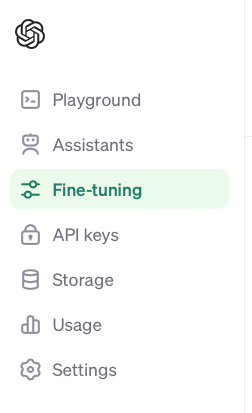

By visiting the "Fine-tuning" section in the playground, you can create, inspect, and cancel your fine-tuning jobs. Create a fine-tuning job by clicking on the big green "+ Create Button" in the upper right of the screen, and uploading the data you just created. You can should choose a GPT-3.5-turbo model. Do not choose the older models like babbage or davinci since they are completion models which use a different format for fine-tuning. 

Once you star training, it will take about an hour to finish.  It's fine to close your web browser.  You can come back to it and inspect the progress of your fine tuning job.  Once it's done you'll see a screen like the one below.

This shows my finished fine-tuned model.  My model name is `ft:gpt-3.5-turbo-1106:ccb-lab-members-fine-tunes:fiction-to-game:90LPqvrc`.  It took 1 hour to train.  My file had 503 training items with 3,630,948 tokens.  The [cost of fine-tuning gpt-3.5-turbo](https://openai.com/pricing#language-models) is $8.00 per 1M tokens, so my total cost was $30. 

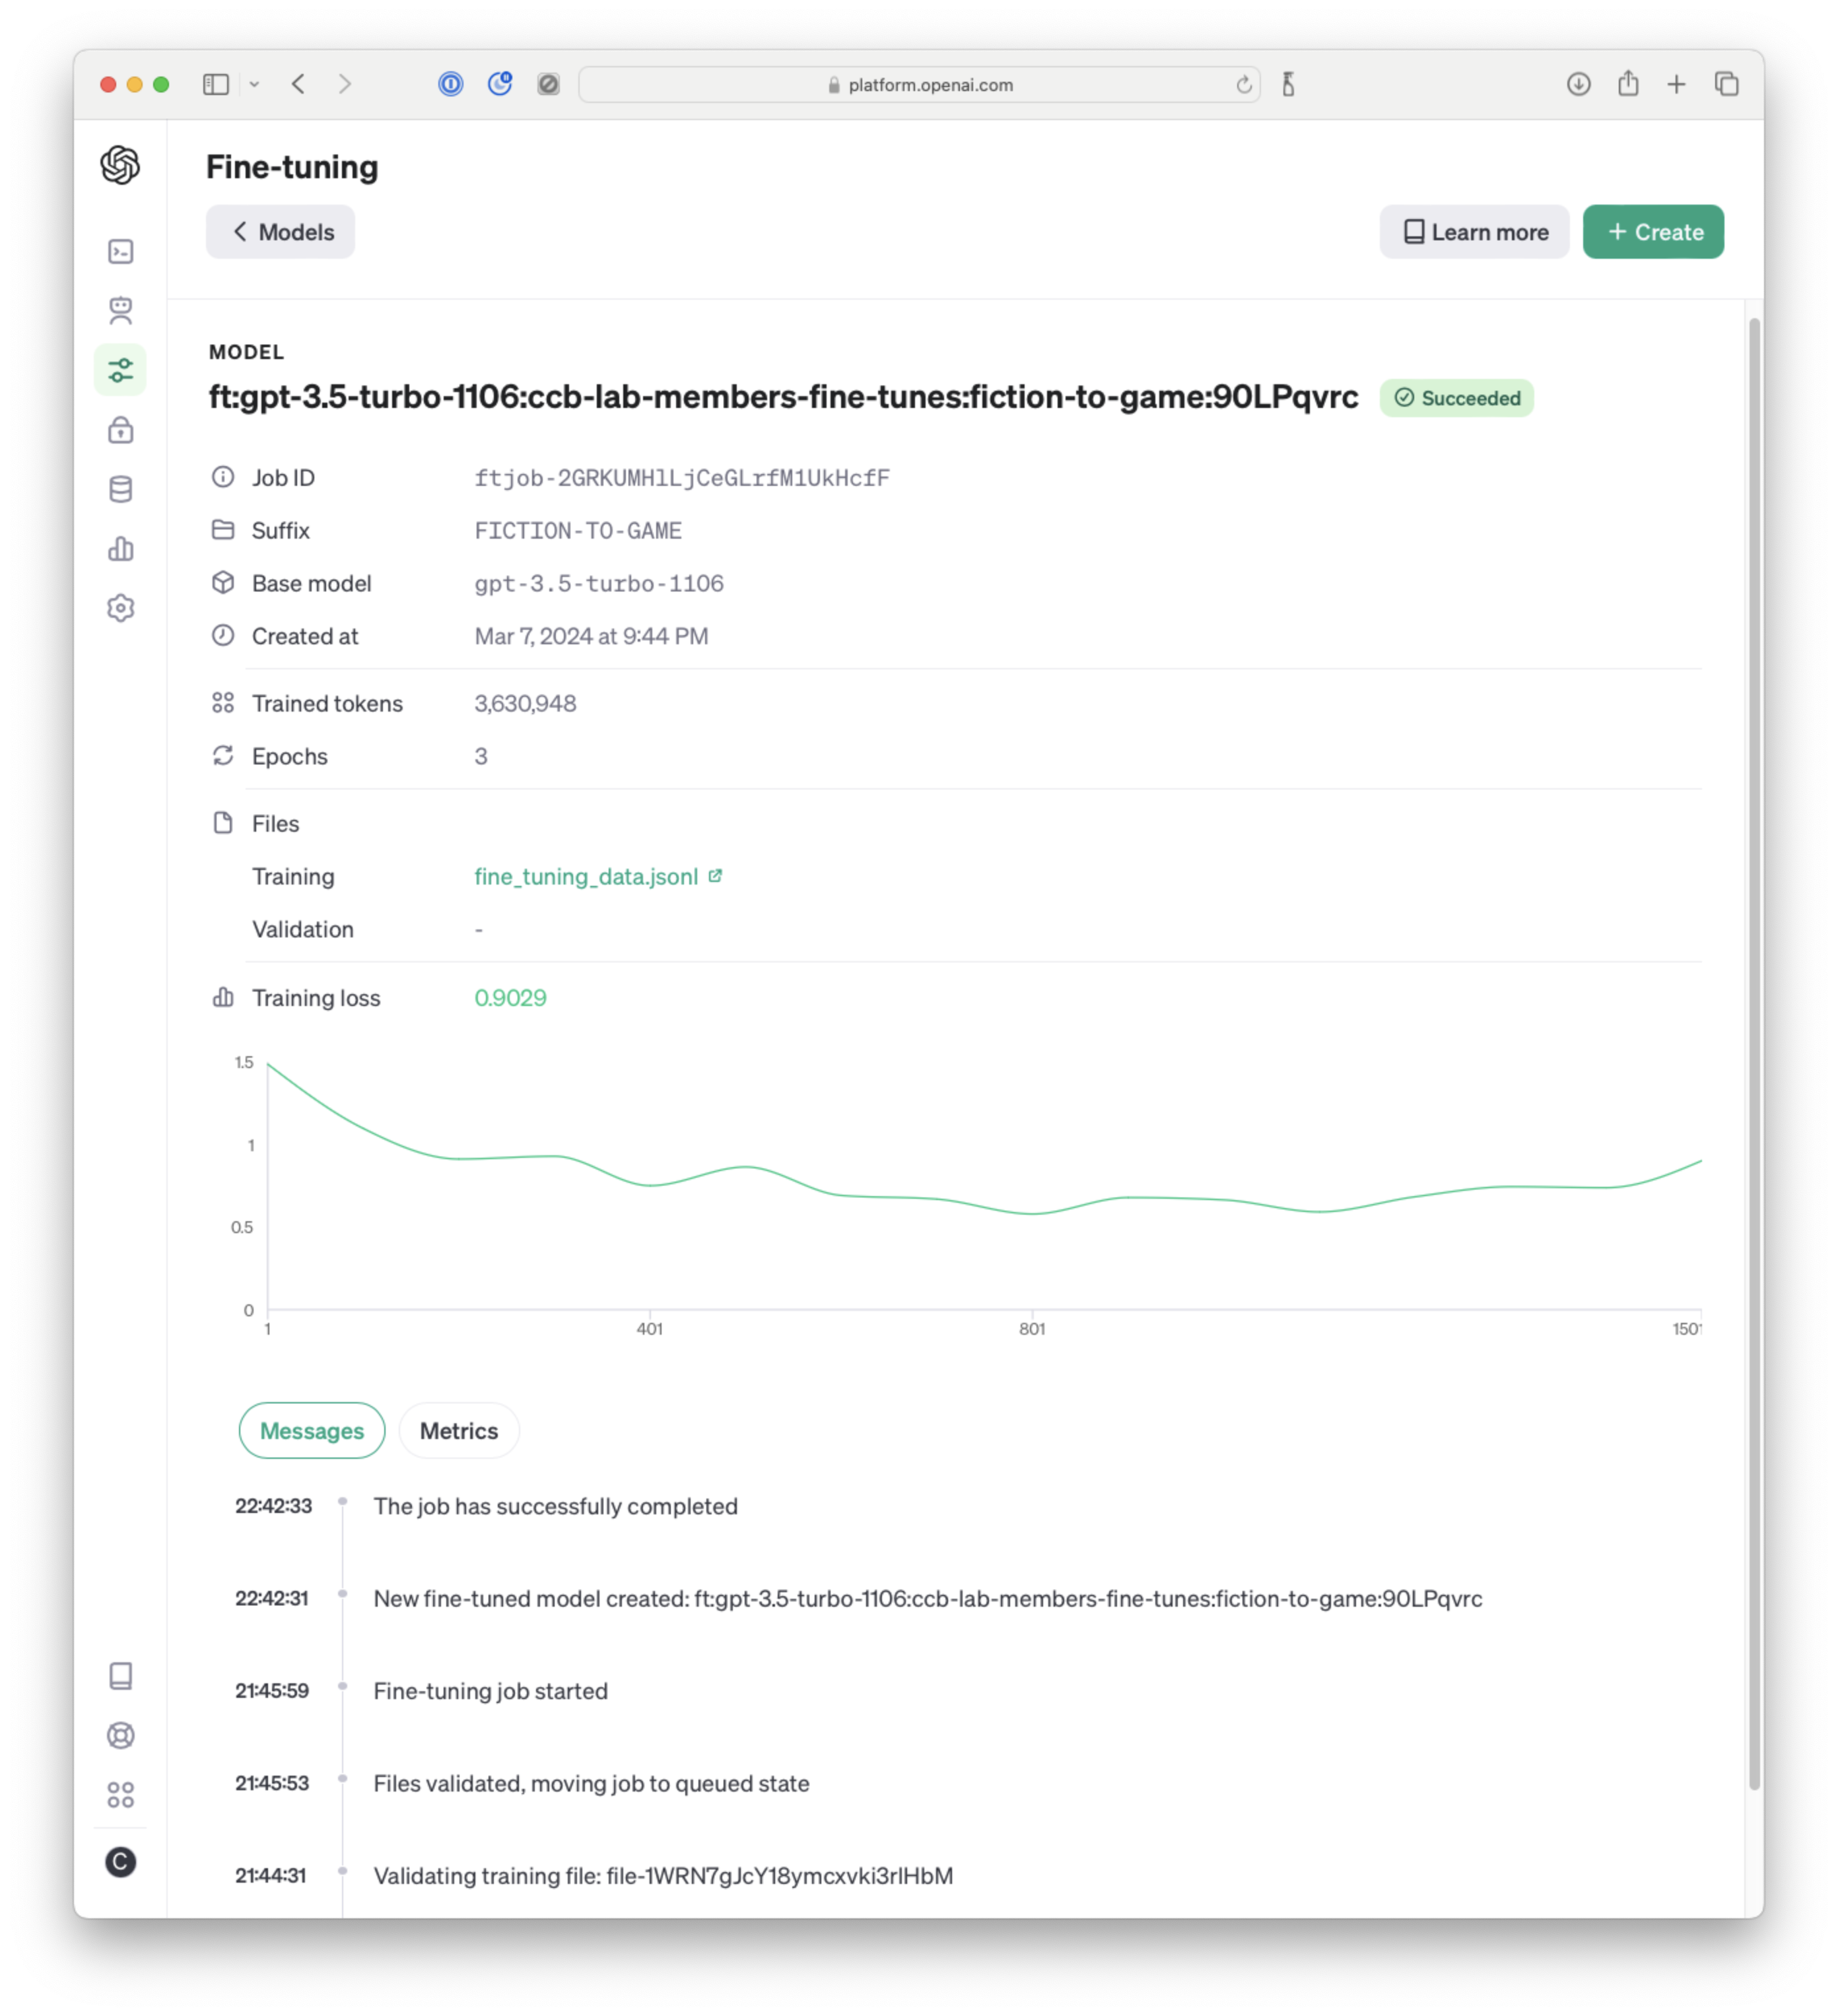


### TODO: Calling your Fine Tuned Model

After getting the ID of fine-tuned model, you can call your model to generate the description of the locations you made in the part 2. You should replace the model with your fine-tuned model as follows:

```
response = client.chat.completions.create(
    model=FINE_TUNED_MODEL,  # Your trained model id should be put here!
    messages=messages,
    temperature=TEMPERATURE,
    max_tokens=MAX_TOKENS,
    top_p=TOP_P,
    ...
)
```

Since fine-tuned models live on your own OpenAI account rather than the class account we're using fpr GPT-4, you'll need to use the default OpenAI configuration (as opposed to Helicone) here. Like in HW2, set your OpenAI API key with the `OPENAI_API_KEY` environment variable or by running the next cell.

In [ ]:
if 'OPENAI_API_KEY' not in os.environ:
    print("You didn't set your OpenAI key to the OPENAI_API_KEY env var on the command line.")
    os.environ['OPENAI_API_KEY'] = getpass("Please enter your OpenAI API Key now: ")

In [ ]:
ft_client = OpenAI()

Now since we have a fine-tuned model, we can generate the actual game state object if any description is given. 

Let's test it out with a few examples we prepared. You might want to experiment multiple times with different inference parameters (e.g. `top_p`, `temperature`, ...) to see how the output changes. Experiment on various combinations, analyze the results depending on the parameters, and how satisfying the fine-tuning performance is.

In [ ]:
def generate_state_from_desc(finetuned_model, system_prompt, description, **kwargs):

  messages = [
      {'role': 'system', 'content': system_prompt},
      {'role': 'user', 'content': description},
      {"role": "assistant", "content": str(locations[0])}
    ]
   # TODO - Messages to put.

  response = ft_client.chat.completions.create(
    model=finetuned_model,
    messages=messages,
    response_format={ "type": "json_object" },
    **kwargs
  )

  output = response.choices[0].message.content
  output = json.loads(output)
  return output

finetuned_model = "ft:gpt-3.5-turbo-0125:personal:700-iftg-hqt:93fNoASd"  # TODO - your finetuned model id.
system_prompt = """
You will be provided with a description of a scene in a text adventure game and an example of a JSON format.
Extract information from the description, and fit the information in a JSON format.
Output a JSON object that reflects the game state.
Don't add things that are not in the description; If there is no informattion for a JSON field, then leave it empty.
"""  #  TODO - your system instruction messsage which was used for fine-tuning.
system_prompt = system_prompt.replace("\n", " ")
locations = load_locations("games-updated")
kwargs = {
    'temperature': 1.0,
    'max_tokens': 4048,
    'top_p': 1.0,
    'frequency_penalty': 0.0,
    'presence_penalty': 0.0,
}

In [ ]:
# Example 1.
example1 = """
Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. 
The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; 
it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. 
Only the photographs on the mantelpiece really showed how much time had passed. 
Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets - but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. 
The room held no sign at all that another boy lived in the house, too. 
Yet Harry Potter was still there, asleep at the moment, but not for long. 
His Aunt Petunia was awake and it was her shrill voice that made the first noise of the day.
"""

scene = generate_state_from_desc(finetuned_model, system_prompt, example1, **kwargs)
print(json.dumps(scene, indent=4))

In [ ]:
# Example 2.
example2 = """
It was a bright cold day in April, and the clocks were striking thirteen. 
Winston Smith, his chin nuzzled into his breast in an effort to escape the vile wind, slipped quickly through the glass doors of Victory Mansions, though not quickly enough to prevent a swirl of gritty dust from entering along with him.
The hallway smelt of boiled cabbage and old rag mats. At one end of it a coloured poster, too large for indoor display, had been tacked to the wall. 
It depicted simply an enormous face, more than a metre wide: the face of a man of about forty−five, with a heavy black moustache and ruggedly handsome features. Winston made for the stairs. 
It was no use trying the lift. Even at the best of times it was seldom working, and at present the electric current was cut off during daylight hours. 
It was part of the economy drive in preparation for Hate Week. 
The flat was seven flights up, and Winston, who was thirty−nine and had a varicose ulcer above his right ankle, went slowly, resting several times on the way. 
On each landing, opposite the lift−shaft, the poster with the enormous face gazed from the wall. 
It was one of those pictures which are so contrived that the eyes follow you about when you move. 
BIG BROTHER IS WATCHING YOU, the caption beneath it ran. 
"""

scene = generate_state_from_desc(finetuned_model, system_prompt, example2, **kwargs)
print(json.dumps(scene, indent=4))

In [ ]:
# Example 3.
example3 = """
In the heat of battle, Jedi Master Obi-Wan Kenobi ignited his lightsaber, the blue blade humming as it sliced through the air. 
His former apprentice, Anakin Skywalker, now Darth Vader, stood opposite him, his red lightsaber gleaming in the dimly lit room. 
Between them stood the Sith Lord, Emperor Palpatine, his dark cloak billowing around him as he unleashed waves of Force lightning at the Jedi. 
The room echoed with the clash of lightsabers and the crackling of electricity, creating a chaotic symphony of destruction. 
Obi-Wan deftly deflected each attack, determination etched on his face as he fought to protect the galaxy from the dark side's grasp. 
Anakin, consumed by his own inner turmoil, hesitated for a moment before launching himself back into the fray, his conflicted heart torn between loyalty to his former master and allegiance to the Emperor. 
The battle raged on, the fate of the galaxy hanging in the balance as three powerful beings clashed in a fight that would determine the course of history.
"""

scene = generate_state_from_desc(finetuned_model, system_prompt, example3, **kwargs)
print(json.dumps(scene, indent=4))

After playing with the examples, discuss your thoughts in terms of the quality, any hallucination (e.g. non-existing characters, items or components), or interestingness depending on the examples and inference parameters. 

TODO: Add an analysis of the results from the examples in your README.md.

# Part 3.  Create a game from a story

For this part, let's make your own game by generating mutliple game states with the custom stories and connect them into a text game.

### TODO: Generating states from story

You can make your own write story, or pick one that you like. For this part you should generate 5 game states with 5 descriptions. You will have 5 locations along with the characters and items. Use your creativity here! 

In [ ]:
scene1 = """ 
The name of the location is the Farm.
Under the soft glow of dawn, Kim arrives at their new home, a farm bequeathed by their grandfather. 
The land sprawls before Kim, a wild tapestry of overgrowth: weeds choke the soil, debris litters the ground, and derelict structures hint at forgotten prosperity. 
Amid this disarray, Kim stands at the precipice of change, the farm's potential as boundless as the horizon.
On the east entrance to the farm, Pelican Town buzzes with the promise of future friendships and stories yet to unfold. 
On the south entrance to the farm, there is the Forest.
Each step on this land is a step towards revival, not just of the farm, but of Kim's connection to the earth and the community. 
"""
scene6 = """ 
The name of the location is Farm. 
One of the Character's name is Kim. 
On the east entrance to Farm, Town buzzes with the promise of future friendships and stories yet to unfold. 
On the south entrance to Farm, there is Forest.
Under the soft glow of dawn, Kim arrives at their new home, a farm bequeathed by their grandfather. 
Amid this disarray, Kim stands at the precipice of change, the farm's potential as boundless as the horizon.
Each step on this land is a step towards revival, not just of the farm, but of Kim's connection to the earth and the community. 
"""

scene2 = """ 
Kim, the player, comes to the Town.
As Kim steps into the sunlit embrace of the Town, the quaint charm of this close-knit community unfolds before them, 
Pierre's General Store stands as a beacon of local commerce and community, its shelves laden with the fruits of the valley, tended by Pierre himself, a merchant passionate about his produce and the townsfolk. 
Nearby, the Clinic offers solace and healing, under the careful watch of Harvey, the town doctor, whose dedication to the health of Pelican Town's residents is as steadfast as the seasons.
The heart of the town, however, beats strongest at the Community Center, a once-vibrant hub now shrouded in mystery and silence, waiting for someone to uncover its secrets and restore it to its former glory. 
In contrast, the Stardrop Saloon buzzes with life, a nightly retreat for the townspeople, where Gus, the jovial barkeep, serves up warmth, stories, and the occasional hearty meal beneath the glow of neon lights. 
Yet, casting a long shadow over these staples of small-town life is the JojaMart, a gleaming monument to modern convenience. 
Managed by Morris, its presence looms as a stark reminder of the encroaching outside world, challenging the town's traditional ways with its cold, fluorescent allure.
The west entrance to town connects to The Farm.
Directly south of town is the Beach.
North of town connects to The Mountain.
"""
scene7 = """ 
The name of the location is Town. 
Kim is a character. Kim is the protagonist of the game. 
Pierre is another character. Pierre is the owner of Pierre's General Store.
Harvey is another character. Harvey is the towrn doctor who works at the Clinic.
Gus is another character. Gus is the owner of Stardrop Saloon, a bar and restaurant.
Morris is another character. Morris is the owner of the JojaMart.
The west entrance to Town connects to Farm.
Directly south of town is Beach.

Pierre's General Store stands as a beacon of local commerce and community, 
its shelves laden with the fruits of the valley, tended by Pierre himself, a merchant passionate about his produce and the townsfolk. 
Nearby, the Clinic offers solace and healing, under the careful watch of Harvey, 
the town doctor, whose dedication to the health of Pelican Town's residents is as steadfast as the seasons.
Stardrop Saloon buzzes with life, a nightly retreat for the townspeople, where Gus, 
the jovial barkeep, serves up warmth, stories, and the occasional hearty meal beneath the glow of neon lights.
Managed by Morris, its presence looms as a stark reminder of the encroaching outside world, 
challenging the town's traditional ways with its cold, fluorescent allure.
"""

scene3 = """
Kim, the player, comes to the Forest.
Beneath the dappled shade of the Forest, Kim finds a world untouched by the march of time,
where every leaf and stone seems to hold a story. 
The forest, alive with the whispers of ancient trees and the gentle babble of hidden streams, invites Kim into its serene embrace. 
Here, the wilderness speaks of mysteries and adventures yet to be uncovered. 
On the forest's edge, the enigmatic Wizard's Tower looms, a beacon for the curious and the brave, where the Wizard, 
keeper of arcane secrets, waits for those daring enough to explore the deeper magics of the valley.
Cindersap Forest has exits to the north into the Farm.
"""
scene8 = """
The name of the location is Forest. 
Kim is a character. Kim is the protagonist of the game. 
Wizard is another character. Wizard lives in Wizard's Tower.
Forest has exits to the north into Farm.

Beneath the dappled shade of the Forest, Kim finds a world untouched by the march of time, where every leaf and stone seems to hold a story. 
The forest, alive with the whispers of ancient trees and the gentle babble of hidden streams, invites Kim into its serene embrace. 
Here, the wilderness speaks of mysteries and adventures yet to be uncovered. 
On the forest's edge, the enigmatic Wizard's Tower looms, a beacon for the curious and the brave, where the Wizard, 
keeper of arcane secrets, waits for those daring enough to explore the deeper magics of the valley.
"""

scene4 = """
Kim, the player, comes to the Beach.
Kim discovers the beach, a tranquil stretch of sand and surf that whispers tales of the sea. 
The rhythmic crash of waves and the salty tang of the air envelop Kim, offering a peaceful respite from the toil of farm life. 
Here, the horizon seems endless, a reminder of the vast world beyond the valley. 
Nestled on this serene shoreline, Willy's Fish Shop stands as a testament to the bounty of the sea. 
Willy, with his sea-worn face and eyes sparkling with stories of the deep, welcomes Kim into his world of nets and knots, 
sharing the rhythms of life that ebb and flow with the tides.
The north passage connects to Pelican Town.
"""
scene9 = """
The name of the location is Beach. 
Kim is a character. Kim is the protagonist of the game. 
Willy is another character. Willy is the owner of Willy's Fish Shop.
The north passage connects to Town.

The rhythmic crash of waves and the salty tang of the air envelop Kim, offering a peaceful respite from the toil of farm life. 
Here, the horizon seems endless, a reminder of the vast world beyond the valley. 
Nestled on this serene shoreline, Willy's Fish Shop stands as a testament to the bounty of the sea. 
Willy, with his sea-worn face and eyes sparkling with stories of the deep, welcomes Kim into his world of nets and knots, 
sharing the rhythms of life that ebb and flow with the tides.
"""

scene5 = """
Kim, the player, comes to the Mountain.
Amid the towering embrace of Stardew Valley's mountains, Kim finds a rugged landscape teeming with the promise of adventure and discovery. 
The crisp mountain air fills their lungs, carrying the scent of pine and the distant echo of wildlife, 
a call to the wild spirit that resides in every heart. 
Here, the land rises to meet the sky, offering breathtaking vistas that stretch the imagination and beckon the bold to explore further. 
The Carpenter's Shop, nestled against this backdrop of natural majesty, stands as a monument to the valley's resilience and ingenuity. 
Robin's friendly greeting and skilled craftsmanship remind Kim of the community's tight-knit bond and the shared endeavor to carve out a life in harmony with the land.
Further along, where the mountain's grasp touches the clouds, lies the entrance to the mines, a gateway to the hidden depths below. 
It's here that the Adventurer's Guild has made its home, a bastion for the brave and the bold. 
Marlon and Gil, the guild's seasoned veterans, welcome Kim with tales of valor and the clang of steel.
This mountain, with its soaring peaks and mysterious caves, offers Kim a path less traveled, 
where the thrill of exploration and the camaraderie of the Adventurer's Guild forge a connection not just to the land, but to the very essence of adventure.
The south passage connects to Pelican Town.
"""
scene10 = """
The name of the location is Mountain.
Kim is a character. Kim is the protagonist of the game. 
Robin is another character. She is the owner of Carpenter's Shop.
Marlon and Gil are two other characters. They are the owner of Adventurer's Guild.
The south passage connects to Town.
Amid the towering embrace of the mountains, Kim finds a rugged landscape teeming with the promise of adventure and discovery. 
The crisp mountain air fills their lungs, carrying the scent of pine and the distant echo of wildlife, 
a call to the wild spirit that resides in every heart. 
Here, the land rises to meet the sky, offering breathtaking vistas that stretch the imagination and beckon the bold to explore further. 
The Carpenter's Shop, nestled against this backdrop of natural majesty, stands as a monument to the valley's resilience and ingenuity. 
Robin's friendly greeting and skilled craftsmanship remind Kim of the community's tight-knit bond and the shared endeavor to carve out a life in harmony with the land.
Further along, where the mountain's grasp touches the clouds, lies the entrance to the mines, a gateway to the hidden depths below. 
It's here that the Adventurer's Guild has made its home, a bastion for the brave and the bold. 
Marlon and Gil, the guild's seasoned veterans, welcome Kim with tales of valor and the clang of steel.
This mountain, with its soaring peaks and mysterious caves, offers Kim a path less traveled, 
where the thrill of exploration and the camaraderie of the Adventurer's Guild forge a connection not just to the land, but to the very essence of adventure.

"""



# story = [scene1, scene2, scene3, scene4, scene5]
story = [scene6, scene7, scene8, scene9, scene10] 
states = []
for scene in story:
    state = generate_state_from_desc(finetuned_model, system_prompt, scene, **kwargs)
    states.append(state)

You can see that while each state looks great, the connections between the states are not correctly defined, since each state was generated independently. You should make them consistent by manually adjusting them, such as adding the connection between two locations, checking/filtering hallucinated objects/characters, or adding empty lists/dictionaries so that the whole game structure fits into the JSON file we first looked into. Make sure to include the required keys by referring to the original game data. If there is any missing components or key, you should also add it to run the game without any error.

Edit your game connections and complete the game in the same JSON format as the data in `games-updated`.

**Note that the code block we gave you is just a skeleton of how to adjust and fix the inconsistencies in your generated data. If you need any fixes or modifications in the skeleton code, feel free to do it, depending on the generated output. Your submission is not strictly required to follow this skeleton code.**

In [ ]:
# TODO: Editing the connections between locations.
world = {}
characters = []
for location in states:
    if not 'characters' in location:
        location['characters'] = {}
    print(location)
    characters += list(location['characters'].values())

In [ ]:
states[0]['connections'] = {
    'east': 'Town', 
    'south': 'Forest'
}
states[0]['travel_descriptions'] = {
    'east': 'Town', 
    'south': 'Forest'
}
states[1]['connections'] = {
    'west': 'Farm', 
    'south': 'Beach', 
    'north': 'Mountain'
}
states[1]['travel_descriptions'] = {
    'west': 'Farm', 
    'south': 'Beach', 
    'north': 'Mountain'
}
states[2]['connections'] = {
    'north': 'Farm'
}
states[2]['travel_descriptions'] = {
    'north': 'Farm'
}
states[3]['connections'] = {
    'north': 'Town'
}
states[3]['travel_descriptions'] = {
    'north': 'Town'
}
states[4]['connections'] = {
    'south': 'Town'
}

states[4]['travel_descriptions'] = {
    'south': 'Town'
}



for state in states:
    state['commands'] = []
    # state['travel_descriptions'] = {}
    state['blocks'] = {}
    state['properties'] = {}

# player = random.choice(characters)
player = characters[0]
world['player'] = player['name']
world['start_at'] = player['location']
world['game_over'] = False
world['game_over_description'] = "Game Over."
world['actions'] = []
world['game_history'] = []

for character in characters:
    for item in character['inventory']:
        if 'location' in item:
            removed_location = item.pop['location']
            print(removed_location)
world['characters'] = characters


world['locations'] = states

with open("custom_game.json", 'w') as f:
    # json.dump(world, f)
    json.dump(world, f, indent=4)

In [34]:
with open('custom_game.json', 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

{
    "player": "Kim",
    "start_at": "Farm",
    "game_over": false,
    "game_over_description": "Game Over.",
    "actions": [],
    "game_history": [],
    "characters": [
        {
            "name": "Kim",
            "description": "Kim is an ambitious newcomer to the Town, eager to breathe new life into their grandfather's neglected farm. With a strong resolve and a heart full of dreams, they're ready to tackle the challenges of rural life.",
            "persona": "As the latest steward of the old family farm, I'm here to turn these overgrown fields into a thriving homestead. I believe in the value of hard work and the power of community. Let's bring this farm back to its former glory together!",
            "location": "Farm",
            "goal": "Revitalize the family farm, integrate into the community, and find a deeper connection to the natural world.",
            "inventory": {}
        },
        {
            "name": "Pierre",
            "description": "The friendly

### TODO: Play your game

You can actually replace the Action Castle we played for HW1 and HW2 with the game you designed. In this part, you will play your game just as you play the Action Castle and evaluate the game in terms of playability, quality, or interestingness.

In [35]:
from text_adventure_games import games
from text_adventure_games.parsing import Parser
from copy import deepcopy
import json
import datetime

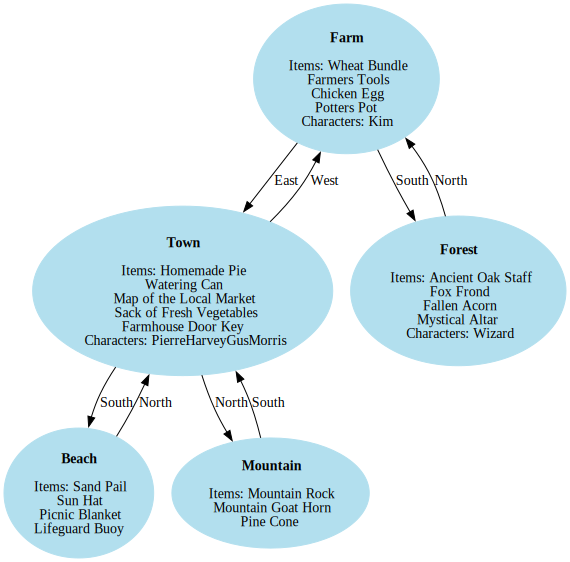

In [36]:

with open("custom_game.json", 'r') as f:
    world = json.load(f)

game = games.Game.from_primitive(deepcopy(world))
parser = Parser(game)

viz = Visualizer(game, verbose=False)
graph = viz.visualize()
graph

In [37]:
game.set_parser(parser)
game.game_loop()

MOUNTAIN
The mountain rises up into the clouds. Cold and stone, a few hardy trees cling
to its face here and there. Mountain goats have been known to traverse the
almost completely vertical face.
Exits:
 * South to Town

You see:
 * Mountain Rock - A large, solid rock from the mountain
 * Mountain Goat Horn - A discarded mountain goat horn
 * Pine Cone - A large forest pine cone, still fresh from the tree


Kim moved to Town Town
TOWN
Town is a bustling place on any given day.  With a farmer's market square in the
center, there are a few stores and clinics set up as well.   It's a simple
setup, a few dirt packing roads web about through some woods leading deeper into
the town.  People can be seen visiting, walking or peddling to and from their
favorite places in town.
Exits:
 * West to Farm
 * South to Beach
 * North to Mountain

You see:
 * Homemade Pie - A fresh, delicious pie cooked by the local bakery.
 * Watering Can - A sturdy metal watering can
 * Map of the Local Market - A det

You can also play with the HW2 parser.  Below is the GPT Parser version.

In [ ]:
from homeworks.hw2_solution.gpt_parser import GptParser
game = games.Game.from_primitive(deepcopy(world))
parser = GptParser(game, verbose=True)

game.set_parser(parser)
game.game_loop()

Alternately, you can play with our GptParser.

In [ ]:
from homeworks.hw2_solution.gpt_parser import GptParser

game = games.Game.from_primitive(deepcopy(data))
parser = GptParser(game, verbose=False, narration_style="Using a dark fantasy suspense style, reveal the scene from a second-person perspective. Paint a vivid picture of the unusual surroundings.")
game.set_parser(parser)
game.game_loop()

Since we didn't add any puzzles, blocks, or conditions, the game is quite bland and there is nothing special to do. Still, it seems really cool that we can actually make a text adventure game with your own custom world. Play your game freely and export the transcript for submission.

In [38]:
def save_game_transcript(game, filename_prefix="game_transcript"):
    current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f"{filename_prefix}-{current_datetime}.json"
    with open(filename, 'w') as file:
        # Pretty-print and save the command history
        json.dump(game.parser.command_history, file, indent=4)
        print(f"Game transcript saved successfully to {filename}")
 

save_game_transcript(game, "game_transcript.json")

Game transcript saved successfully to game_transcript.json-2024-03-19_12-37.json


TODO: In your README.md give your thoughts about the game that you created.  Is it any good?  What story did you pick?  How was the game similar or dissimilar to the story you picked?  Give some examples of interesting outputs from your game.

# What to submit?
- Completed `hw3.ipynb`
- Your synthetic training data with your augmented prompts and descriptions `synthetic_data.jsonl`
- Your fine-tuning data `fine_tuning_data.jsonl`
- Your completed game state `custom_game.json`. 
- A game trancript `game_transcript.json` that shows that you can play it.
- A README.md file that discusses what you did in the homework. 